<a href="https://colab.research.google.com/github/nulllpointer/Thesis/blob/master/Rice_Leaf_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")




In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')
path= '/content/drive/My Drive/plant_classification'
path = Path(path)
data_path = path/'datasets/plant_leaf'
data_path


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PosixPath('/content/drive/My Drive/plant_classification/datasets/plant_leaf')

# **Load Dataset**

['acer_platanoides', 'acer_saccharinum', 'aesculus_flava', 'ailanthus_altissima', 'amelanchier_canadensis', 'betula_alleghaniensis', 'betula_nigra', 'carpinus_betulus', 'castanea_dentata', 'catalpa_speciosa', 'chamaecyparis_thyoides', 'chionanthus_retusus', 'cornus_florida', 'evodia_daniellii', 'ficus_carica', 'fraxinus_nigra', 'fraxinus_pennsylvanica', 'ilex_opaca', 'juglans_cinerea', 'juniperus_virginiana', 'maclura_pomifera', 'magnolia_acuminata', 'magnolia_soulangiana', 'magnolia_tripetala', 'malus_angustifolia', 'malus_coronaria', 'malus_pumila', 'nyssa_sylvatica', 'oxydendrum_arboreum', 'phellodendron_amurense', 'picea_orientalis', 'picea_pungens', 'pinus_densiflora', 'pinus_echinata', 'pinus_parviflora', 'pinus_sylvestris', 'populus_grandidentata', 'prunus_serrulata', 'quercus_falcata', 'quercus_macrocarpa', 'quercus_marilandica', 'quercus_michauxii', 'quercus_montana', 'quercus_muehlenbergii', 'quercus_phellos', 'quercus_stellata', 'quercus_virginiana', 'salix_babylonica', 'ste

LabelLists;

Train: LabelList (1704 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
aesculus_flava,aesculus_flava,aesculus_flava,aesculus_flava,aesculus_flava
Path: /content/drive/My Drive/plant_classification/datasets/plant_leaf;

Valid: LabelList (426 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
quercus_stellata,nyssa_sylvatica,quercus_macrocarpa,quercus_phellos,quercus_stellata
Path: /content/drive/My Drive/plant_classification/datasets/plant_leaf;

Test: None

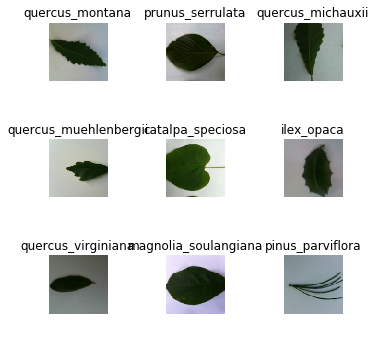

In [ ]:
# **Load Dataset**
bs = 64
tfms = get_transforms(do_flip=False, flip_vert=True)
data = ImageDataBunch.from_folder(data_path, ds_tfms=tfms, size=bs, valid_pct=0.2)
data.show_batch(rows=3, figsize=(5,5))
print(data.classes)
len(data.classes),data.c
data.label_list

# DenseNet Models

In [ ]:
densenet_pretrained = cnn_learner(data, models.densenet201, pretrained=True, metrics=[error_rate, accuracy])
densenet_pretrained.fit_one_cycle(15)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.455711,3.081618,0.725352,0.274648,05:20
1,2.672525,1.132963,0.276995,0.723005,03:06
2,1.643540,0.590304,0.147887,0.852113,03:06
3,1.110788,0.375700,0.117371,0.882629,03:05
4,0.808271,0.270774,0.091549,0.908451,03:05
5,0.587078,0.267121,0.082160,0.917840,03:06
6,0.447747,0.235482,0.086854,0.913146,03:06
7,0.344308,0.235692,0.070423,0.929577,03:06
8,0.273152,0.219644,0.068075,0.931925,03:07
9,0.216326,0.199739,0.065728,0.934272,03:06


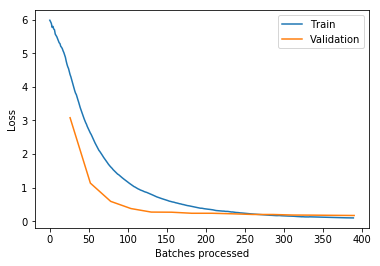

In [ ]:
 densenet_pretrained.recorder.plot_losses()
densenet_pretrained.save('densenet-15-epcohs')

In [ ]:
densenet = cnn_learner(data, models.densenet201, pretrained=False, metrics=accuracy)
densenet.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,4.106943,4.495895,0.107981,03:51
1,3.206776,2.004588,0.403756,03:49
2,2.686921,1.249176,0.612676,03:52
3,2.237018,1.210697,0.645540,03:50
4,1.901830,0.977894,0.697183,03:50


# Resnet50

In [ ]:
resnet50 = cnn_learner(data, models.resnet50, pretrained=True, metrics=accuracy)
resnet50.fit_one_cycle(5)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 16.8MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,3.610798,1.901797,0.476526,02:12
1,2.249986,0.898127,0.725352,02:12
2,1.670443,0.715447,0.791080,02:12
3,1.263492,0.642296,0.823944,02:12
4,1.028901,0.607909,0.833333,02:11


In [ ]:
resnet50 = cnn_learner(data, models.resnet50, pretrained=False, metrics=accuracy)
resnet50.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,5.037381,8.350173,0.018779,02:46
1,4.495028,4.708725,0.037559,02:46
2,4.172807,3.009391,0.180751,02:46
3,3.879745,2.844444,0.220657,02:47
4,3.622169,2.665630,0.260563,02:47


# squeezenet1_1 Model

In [ ]:
squeezenet1_1 = cnn_learner(data, models.squeezenet1_1, pretrained=True,  metrics=accuracy)
squeezenet1_1.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,4.297912,1.928280,0.478873,00:35
1,2.937337,1.451128,0.579812,00:34
2,2.292920,1.303586,0.664319,00:34
3,1.900169,1.760568,0.690141,00:34
4,1.614006,2.095699,0.687793,00:34


In [ ]:
squeezenet1_1 = cnn_learner(data, models.squeezenet1_1, pretrained=False, metrics=accuracy)
squeezenet1_1.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,4.652868,3.370335,0.124413,00:38
1,4.038627,2.725036,0.326291,00:38
2,3.546953,2.184566,0.368545,00:38
3,3.139079,1.746316,0.509390,00:38
4,2.802517,1.610403,0.539906,00:39


# Pretained VGG Model

In [ ]:
learn = cnn_learner(data, models.vgg19_bn, pretrained=True, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:20<00:00, 28.1MB/s]


In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,4.465428,2.144280,0.511737,10:02
1,2.723429,0.890612,0.748826,04:26
2,1.849106,0.632466,0.819249,04:22
3,1.379649,0.587831,0.807512,04:27
4,1.080064,0.553525,0.835681,04:25


# **Model Interpretation**

[('juglans_cinerea', 'fraxinus_nigra', 4),
 ('castanea_dentata', 'quercus_montana', 3),
 ('fraxinus_nigra', 'evodia_daniellii', 2),
 ('juglans_cinerea', 'castanea_dentata', 2),
 ('magnolia_acuminata', 'nyssa_sylvatica', 2),
 ('quercus_stellata', 'malus_coronaria', 2),
 ('quercus_virginiana', 'nyssa_sylvatica', 2)]

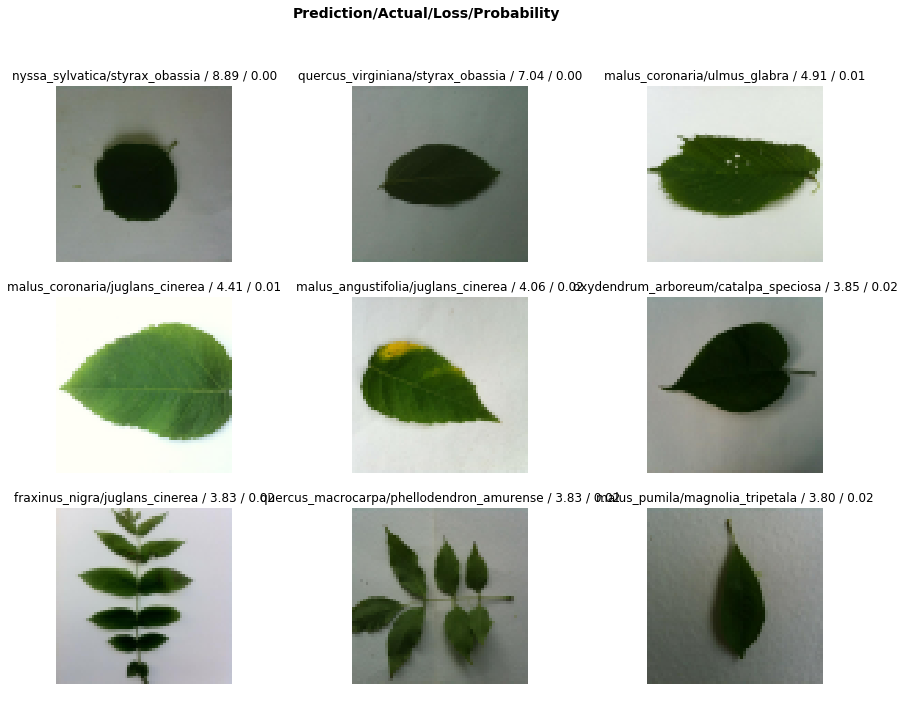

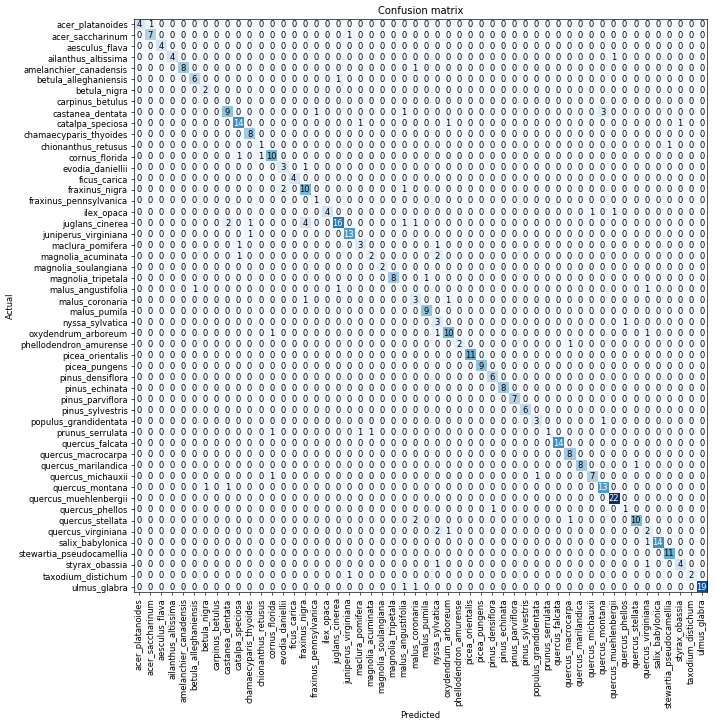

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused(min_val=2)



# **Saving Model**

In [ ]:
learn.save('vgg-stage-1')

# Learning **Rate** Fine Tuning

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


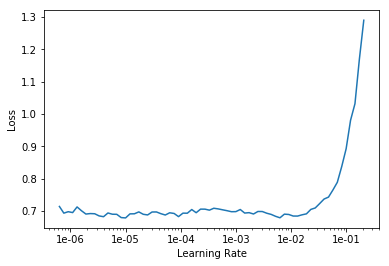

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.682794,0.482429,0.854460,06:09
1,0.616524,0.417584,0.882629,06:12
2,0.566868,0.493039,0.861502,06:10
3,0.580501,0.568185,0.845070,06:08
4,0.564343,0.374543,0.887324,06:12
5,0.545944,0.411475,0.906103,06:07
6,0.479573,0.379652,0.903756,06:10
7,0.423197,0.420928,0.908451,06:10
8,0.357540,0.300533,0.941315,06:12
9,0.285607,0.314823,0.931925,06:10


In [ ]:
learn.save('vgg-stage-2')
learn.load('vgg-stage-2')
learn.export()


# Fine tuning DenseNet


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


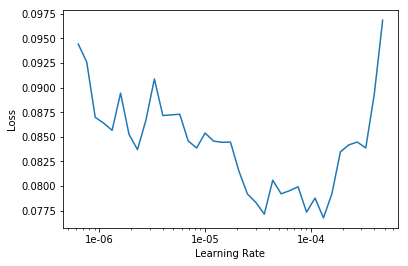

In [ ]:
densenet_pretrained.unfreeze()
densenet_pretrained.lr_find()
densenet_pretrained.recorder.plot()

In [ ]:
densenet_pretrained.load()
densenet_pretrained.fit_one_cycle(10, max_lr=slice(1e-4,1e-4))

In [ ]:
densenet_pretrained.load('densenet-15-epcohs')
densenet_pretrained.fit_one_cycle(10, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.089580,0.169182,0.053991,0.946009,03:36
1,0.077375,0.166032,0.056338,0.943662,03:34
2,0.079249,0.158407,0.046948,0.953052,03:36
3,0.078651,0.161855,0.056338,0.943662,03:40
4,0.083199,0.158539,0.049296,0.950704,03:42
5,0.084540,0.159022,0.053991,0.946009,03:40
6,0.075812,0.154320,0.049296,0.950704,03:44
7,0.067410,0.150150,0.046948,0.953052,03:49
8,0.067307,0.153190,0.049296,0.950704,03:49
9,0.066462,0.157871,0.049296,0.950704,03:48


In [ ]:
densenet_pretrained.recorder.plot_losses()

In [ ]:
path = Path('/content/drive/My Drive/plant_classification')
%cd /content/drive/My Drive/plant_classification
densenet_pretrained.save('densenet-fine-tuned')
densenet_pretrained.load('densenet-fine-tuned')
densenet_pretrained.export('densenet-fine-tuned')

[Errno 2] No such file or directory: '/content/drive/My Drive/plant_classification'
/content
